## Structure learning in decomposable graphical models

Two examples of the particle Gibbs sampler for Bayesian structure learning are shown in this section for both continuous and discrete data.

In [22]:
%matplotlib inline

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns

from trilearn.graph import trajectory
import trilearn.graph.graph as glib
import trilearn.graph.decomposable as dlib
import trilearn.distributions.g_intra_class as gic
import trilearn.auxiliary_functions as aux
from trilearn.distributions import discrete_dec_log_linear as loglin
from trilearn import pgibbs
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Discrete log-linear models

The first two rows (i.e. index 0 and 1), of the file should specify the labels and the levels of the corresponding variables. 

#### Czech auto workers data

In [23]:
aw_df = pd.read_csv("sample_data/czech_autoworkers.csv", header=[0, 1]) 

In [24]:
aw_df.head(2)

,smoke,mental,phys,bloodp,lipo,coron
,2,2,2,2,2,2
0,1,1,1,0,0,0
1,1,1,1,0,0,0


In [25]:
aw_df.shape

(1841, 6)

In [26]:
np.random.seed(1)
aw_graph_traj = pgibbs.sample_trajectory_loglin(dataframe=aw_df, n_particles=20, n_samples=1000, reset_cache=False)

Particle Gibbs samples: 100%|██████████| 1000/1000 [00:19<00:00, 51.88it/s]


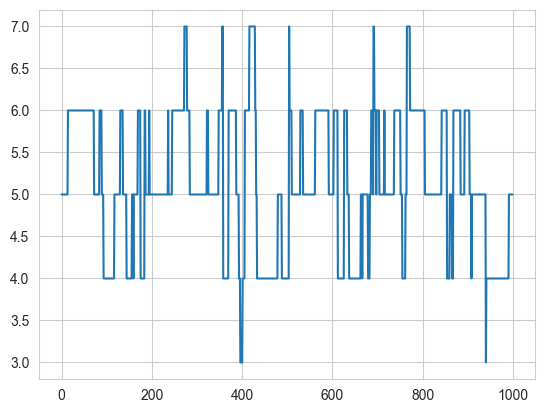

In [27]:
aw_graph_traj.size().plot();
plt.show()

In [28]:
aw_graph_traj.graph_diff_trajectory_df(labels=[x[0] for x in aw_df.columns])


   index                                              added removed  score
0     -2  [smoke-mental;smoke-phys;smoke-bloodp;smoke-li...      []      0
   index added                                            removed  score
0     -1    []  [smoke-mental;smoke-phys;smoke-bloodp;smoke-li...      0


,index,added,removed,score
0,-2,[smoke-mental;smoke-phys;smoke-bloodp;smoke-li...,[],0.000000
0,-1,[],[smoke-mental;smoke-phys;smoke-bloodp;smoke-li...,0.000000
0,0,[mental-phys;phys-coron;phys-smoke;phys-lipo;s...,[],-6738.441168
0,4,[],[],-6738.441168
0,8,[],[],-6738.441168
...,...,...,...,...
0,966,[],[],-6733.884977
0,974,[],[],-6733.884977
0,976,[],[],-6733.884977
0,977,[],[],-6733.884977


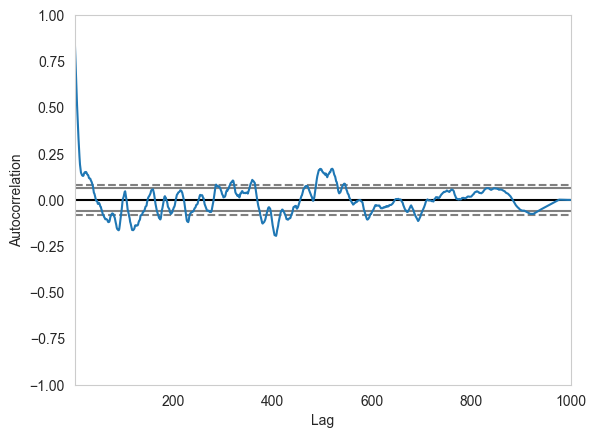

In [29]:
autocorrelation_plot(aw_graph_traj.size());
plt.show()

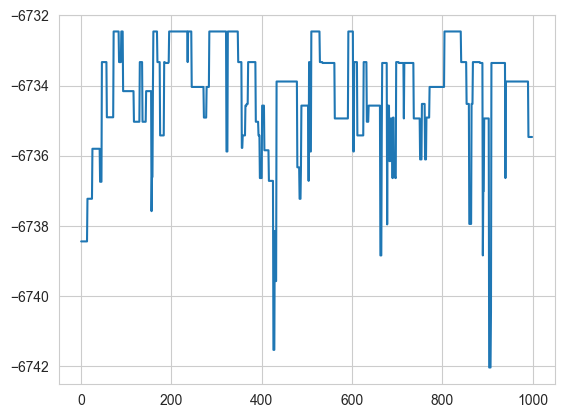

In [30]:
aw_graph_traj.log_likelihood().plot();
plt.show()

[[0.   0.01 0.   0.   0.   0.  ]
 [0.01 0.   0.01 0.   0.01 0.01]
 [0.   0.01 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.   0.   0.   0.01]
 [0.   0.01 0.   0.   0.01 0.  ]]
[[0.    0.004 0.    0.    0.    0.   ]
 [0.004 0.    0.004 0.004 0.004 0.   ]
 [0.    0.004 0.    0.    0.    0.   ]
 [0.    0.004 0.    0.    0.004 0.   ]
 [0.    0.004 0.    0.004 0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]]
[[0.    0.011 0.    0.    0.    0.   ]
 [0.011 0.    0.011 0.011 0.011 0.   ]
 [0.    0.011 0.    0.    0.    0.   ]
 [0.    0.011 0.    0.    0.011 0.011]
 [0.    0.011 0.    0.011 0.    0.   ]
 [0.    0.    0.    0.011 0.    0.   ]]
[[0.    0.001 0.    0.    0.    0.   ]
 [0.001 0.    0.001 0.001 0.    0.   ]
 [0.    0.001 0.    0.001 0.001 0.   ]
 [0.    0.001 0.001 0.    0.    0.001]
 [0.    0.    0.001 0.    0.    0.   ]
 [0.    0.    0.    0.001 0.    0.   ]]
[[0.    0.003 0.    0.    0.    0.   ]
 [0.003 0.    0.003 0.    0.003 0.   ]
 [0.    0.003 0.  

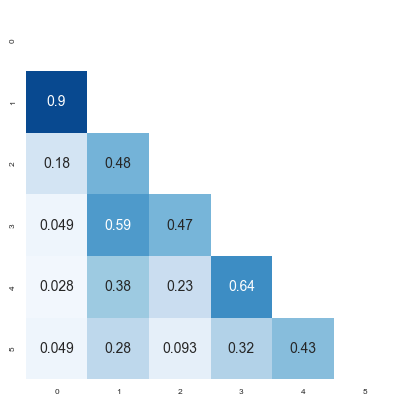

In [38]:
aux.plot_heatmap(aw_graph_traj.empirical_distribution().heatmap(), annot=True)
plt.show()

In [32]:
aw_top = aw_graph_traj.empirical_distribution().mode(5)
print("Probability\tEdge list: ")
for graph, prob in aw_top:
    print(str(prob)+ "\t\t"  + str(list(graph.edges())))

Probability	Edge list: 
0.05400000000000004		[(1, 2), (2, 0), (2, 4), (3, 4), (4, 0)]
0.046000000000000034		[(1, 2), (1, 5), (2, 0), (2, 4), (0, 3), (0, 4)]
0.04300000000000003		[(1, 2), (2, 0), (2, 4), (0, 4), (4, 3)]
0.04100000000000003		[(1, 2), (2, 0), (2, 4), (0, 3), (0, 4)]
0.04100000000000003		[(1, 2), (2, 0), (2, 4), (0, 4)]


In [33]:
aw_mapgraph = aw_graph_traj.empirical_distribution().mode(1)[0][0]

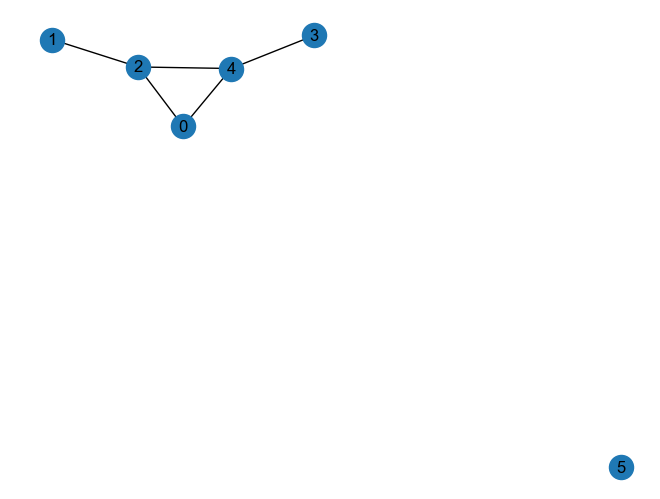

In [34]:
nx.draw(aw_mapgraph, with_labels=True)
plt.show()

### Gaussian graphical models (GGMs)

#### Simualted AR(1-5)-model

In [35]:
np.random.seed(2) # generates same data as in the paper
ar_graph = dlib.sample_random_AR_graph(n_dim=50, max_bandwidth=5)
aux.plot_heatmap(nx.to_numpy_array(ar_graph))
ar_cov_mat = gic.cov_matrix(ar_graph, 0.9, 1.0)
ar_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(50), ar_cov_mat, 100))

AttributeError: module 'networkx' has no attribute 'from_numpy_matrix'

In [ ]:
ar_df.shape

In [ ]:
ar_df.head(5)

In [ ]:
nx.draw(ar_graph, with_labels=True)

In [ ]:
np.random.seed(1)

In [ ]:
ar_graph_traj_seed1 = pgibbs.sample_trajectory_ggm(dataframe=ar_df, n_particles=50, alpha=0.5, beta=0.8, radius=5, n_samples=5000, reset_cache=True)

In [ ]:
ar_graph_traj_seed1.size().plot();

In [ ]:
aux.plot_heatmap(ar_graph_traj_seed1.empirical_distribution(4500).heatmap(), xticklabels=5, yticklabels=5 )

In [ ]:
ar_graph_traj_seed1.logl =[]
ar_graph_traj_seed1.log_likelihood(0).plot();

In [ ]:
ar_graph_traj = pgibbs.sample_trajectory_ggm(dataframe=ar_df, n_particles=50, alpha=0.5, beta=0.8, radius=5, n_samples=5000, reset_cache=True)

In [ ]:
ar_graph_traj.size().plot();

In [ ]:
autocorrelation_plot(ar_graph_traj.size());

In [ ]:
nx.draw(ar_mapgraph, with_labels=True)

### Simulated 15 nodes log-linear model

In [ ]:
loglin_graph = nx.Graph()
loglin_graph.add_nodes_from(range(15))
loglin_graph.add_edges_from([(0, 11), (0, 7), (1, 8), (1, 6), (2, 4), (3, 8), (3, 9),
                             (3, 10), (3, 4), (3, 6), (4, 6), (4, 8), (4, 9), (4, 10),
                             (5, 10), (5, 6), (6, 8), (6, 9), (6, 10), (7, 11), (8, 9),
                             (8, 10), (8, 11), (9, 10), (10, 11), (12, 13)])

In [ ]:
aux.plot_heatmap(nx.to_numpy_array(loglin_graph))

In [ ]:
nx.draw(loglin_graph, with_labels=True)

In [ ]:
np.random.seed(1)
levels = np.array([range(2)] * loglin_graph.order())
table = loglin.sample_prob_table(loglin_graph, levels, 1.0)

In [ ]:
np.random.seed(5)
loglin_df = pd.DataFrame(loglin.sample(table, 1000))
loglin_df.columns = [range(loglin_graph.order()), [len(l) for l in levels]]

In [ ]:
loglin_df.head()

In [ ]:
loglin_df.shape

In [ ]:
loglin_graph_traj = pgibbs.sample_trajectory_loglin(dataframe=loglin_df, n_particles=100, alpha=0.2, beta=0.8, n_samples=10000, 
                                                    reset_cache=True)

In [ ]:
loglin_graph_traj.size().plot();

In [ ]:
autocorrelation_plot(loglin_graph_traj.size());

In [ ]:
loglin_graph_traj.log_likelihood().plot();

In [ ]:
aux.plot_heatmap(loglin_graph_traj.empirical_distribution(5).heatmap())

In [ ]:
loglin_mapgraph = loglin_graph_traj.empirical_distribution().mode(1)[0][0]
aux.plot_heatmap(nx.to_numpy_array(loglin_mapgraph))

In [ ]:
nx.draw(loglin_mapgraph, with_labels=True)